In [1]:
import matplotlib
import pandas as pd

import pylab as PL
import random as RD
import scipy as SP
import numpy as np
import matplotlib.pyplot as plt

RD.seed()

In [17]:
#MFA to a 2-D binary CA model with majority rule on Moore neighborhoods

#simulation
width = 50
height = 50
size = width*height

def init(dens=0.5):
    global time, config, nextConfig, density, densities
    
    density = dens
    densities = [density]
    time = 0
    num_of_ones = int(density*height*width)
    config = SP.zeros([height, width])
    random_location_ones = SP.random.choice(height*width, num_of_ones, replace=False)
    for loc in random_location_ones:
        config[int(loc/width),loc%width] = 1
    
    nextConfig = SP.zeros([height, width])

def draw():
    PL.cla()
    PL.pcolor(config, vmin = 0, vmax = 2, cmap = PL.cm.jet)
    PL.axis('image')
    PL.title('t = ' + str(time))
    PL.show()

def step():
    global time, config, nextConfig

    time += 1
    for x in range(width):
        for y in range(height):
            state = config[y, x]
            others = 0 
            for dx in range(-1, 2):
                for dy in range(-1, 2):
                    if config[(y+dy)%height, (x+dx)%width] == (state+1)%2:
                        others+=1
                        if others>=5:
                            state = (state+1)%2
            nextConfig[y, x] = state
    
    densities.append(SP.sum(config)/(width*height))

    config, nextConfig = nextConfig, config

In [19]:
def mfa_majority_rule(x):
    return 70*x**9 - 315*x**8 + 540*x**7 - 420*x**6 + 126*x**5

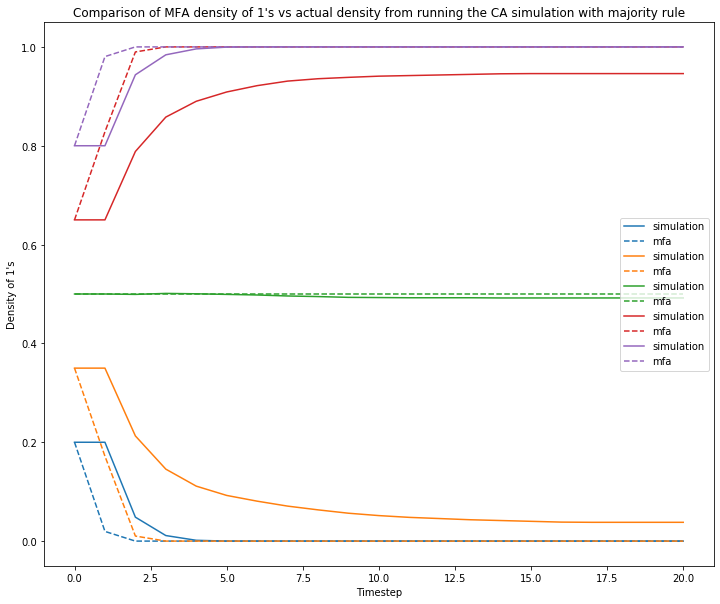

In [22]:
init_densities = np.linspace(0.2,0.8,5)
plt.figure(figsize=(12,10))
for d in init_densities:
    init(d)
    mfa_progression = [d]
    current_d = d
    for _ in range(20):
        step()
        next_d = mfa_majority_rule(current_d)
        mfa_progression.append(next_d)
        current_d = next_d
    p1 = plt.plot(SP.arange(time+1),densities, label = "simulation".format(d))
    p1color = p1[0].get_color()
    p2 = plt.plot(SP.arange(time+1),mfa_progression, label = "mfa", color =p1color, linestyle = "--")    
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Density of 1's")
plt.title("Comparison of MFA density of 1's vs actual density from running the CA simulation with majority rule")
plt.show()

In [37]:
def pdf_next_seq(seq,k,N):
    prod = 1
    ones_left = k-1
    for i in range(len(seq)):
        if seq[i] == "1":
            prod*=ones_left/(N-1-i)
            ones_left-=1
        elif seq[i] == "0":
            prod*=(1-ones_left/(N-1-i))
    return prod

class MFA_traffic:
    def __init__(self,k=20,N=100):
        self.k = k
        self.N = N
        self.saved = {}
        
#     def pdf_next_seq(seq):
#         k = self.k
#         N = self.N
#         prod = 1
#         ones_left = k-1
#         for i in range(len(seq)):
#             if seq[i] == "1":
#                 prod*=ones_left/(N-1-i)
#                 ones_left-=1
#             elif seq[i] == "0":
#                 prod*=(1-ones_left/(N-1-i))
#         return prod
    
    def pdf_velocity(self,v,t):
        if "p_{}_{}".format(v,t) in self.saved:
            return self.saved["p_{}_{}".format(v,t)]
        else:
            k = self.k
            N = self.N

            if t == 0:
                if v == 0:
                    return (k-1)/(N-1)
                elif v == 1:
                    return 1-(k-1)/(N-1)
                else:
                    return 0
            else:
                
                pv_0 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(0,t-1)
                pv_1 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(1,t-1)
                pv_2 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(2,t-1)
                pv_3 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(3,t-1)
                pv_4 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(4,t-1)
                pv_5 = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(5,t-1)
        
                if v == 0:
                    result = (k-1)/(N-1)
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                elif v == 1:
                    term1 = pv_0*pdf_next_seq("0",k,N)
                    term2 = (pv_1+pv_2+pv_3+pv_4+pv_5)*pdf_next_seq("01",k,N)
                    result = term1+term2
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                elif v == 2:
                    term1 = pv_1*pdf_next_seq("00",k,N)
                    term2 = (pv_2+pv_3+pv_4+pv_5)*pdf_next_seq("001",k,N)
                    result = term1+term2
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                elif v == 3:
                    term1 = pv_2*pdf_next_seq("000",k,N)
                    term2 = (pv_3+pv_4+pv_5)*pdf_next_seq("0001",k,N)
                    result = term1+term2
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                elif v == 4:
                    term1 = pv_3*pdf_next_seq("0000",k,N)
                    term2 = (pv_4+pv_5)*pdf_next_seq("0001",k,N)
                    result = term1+term2
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                elif v == 5:
                    result = (pv_4+pv_5)*pdf_next_seq("00000",k,N)
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
    
    def pdf_flow(self,t=200):
        k = self.k
        N = self.N
        return (
            (k/N)*(1-self.pdf_velocity(1,t))
        )+(
            (k/N)*pdf_next_seq("0",k,N)*np.sum([self.pdf_velocity(v,t) for v in range(2,6)])
        )+(
            (k/N)*pdf_next_seq("00",k,N)*np.sum([self.pdf_velocity(v,t) for v in range(3,6)])
        )+(
            (k/N)*pdf_next_seq("000",k,N)*np.sum([self.pdf_velocity(v,t) for v in range(4,6)])
        )+(
            (k/N)*pdf_next_seq("0000",k,N)*np.sum([self.pdf_velocity(v,t) for v in range(4,6)])
        )+(
            (k/N)*pdf_next_seq("00000",k,N)*self.pdf_velocity(5,t)
        )
    
    def flow(self,t=200):
        k = self.k
        N = self.N
        avg_timestep_size = np.sum([self.pdf_velocity(v,t)*v for v in range(6)])
        time_full_lap = N/avg_timestep_size
        return k/time_full_lap
                